Loaded 1 coordinates from message.txt.


Done! Images saved to: sentinel_tree_images


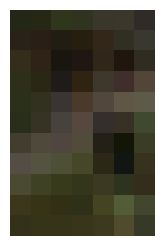

In [ ]:
import os
from sentinelhub import (
    SHConfig, BBox, CRS, MimeType,
    SentinelHubRequest, DataCollection, bbox_to_dimensions
)
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os

# Load environment variables from sentinel.env
load_dotenv("/Users/btaspinar/Documents/sentinel.env", override=True)

# Now Sentinel Hub can read them
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = os.getenv("SH_CLIENT_ID")
config.sh_client_secret = os.getenv("SH_CLIENT_SECRET")

# Input coordinate file
coord_file = "message.txt"
output_dir = "sentinel_tree_images"
os.makedirs(output_dir, exist_ok=True)

# Image parameters
size_m = 100  # tile size in meters (width/height)
resolution = 10  # meters per pixel (Sentinel-2 native resolution)

# ---------------------------------
# READ COORDINATES
# ---------------------------------
coords = []
with open(coord_file, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 2:
            try:
                lat, lon = float(parts[0]), float(parts[1])
                coords.append((lat, lon))
            except ValueError:
                pass

print(f"Loaded {len(coords)} coordinates from {coord_file}.")

# ---------------------------------
# DOWNLOAD SENTINEL-2 RGB IMAGES
# ---------------------------------
for i, (lat, lon) in enumerate(tqdm(coords, desc="Downloading Sentinel-2 images")):
    # Define bounding box around the point
    bbox = BBox([lon - 0.0005, lat - 0.0005, lon + 0.0005, lat + 0.0005], crs=CRS.WGS84)
    size = bbox_to_dimensions(bbox, resolution=resolution)
    
    # Define request
    request = SentinelHubRequest(
        evalscript="""
        //VERSION=3
        function setup() {
          return {
            input: ["B04", "B03", "B02"],
            output: { bands: 3 }
          };
        }
        function evaluatePixel(sample) {
          return [3.0 * sample.B04, 3.0 * sample.B03, 3.0 * sample.B02];
        }
        """,
        input_data=[SentinelHubRequest.input_data(data_collection=DataCollection.SENTINEL2_L2A)],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=bbox,
        size=size,
        config=config,
    )

    try:
        image_data = request.get_data()[0]
        image = Image.fromarray(image_data)
        image.save(os.path.join(output_dir, f"tree_{i+1}.png"))
    except Exception as e:
        print(f"Failed to fetch image for point {lat}, {lon}: {e}")

print("Done! Images saved to:", output_dir)

# ---------------------------------
# VISUALIZE A FEW IMAGES
# ---------------------------------
sample_files = sorted(os.listdir(output_dir))[:9]
plt.figure(figsize=(10, 10))
for i, img_name in enumerate(sample_files):
    img = Image.open(os.path.join(output_dir, img_name))
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.show()


In [9]:
config

SHConfig(
  instance_id='',
  sh_client_id='********************************e836',
  sh_client_secret='****************************TqUF',
  sh_base_url='https://services.sentinel-hub.com',
  sh_auth_base_url=None,
  sh_token_url='https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
  max_retries=None,
)

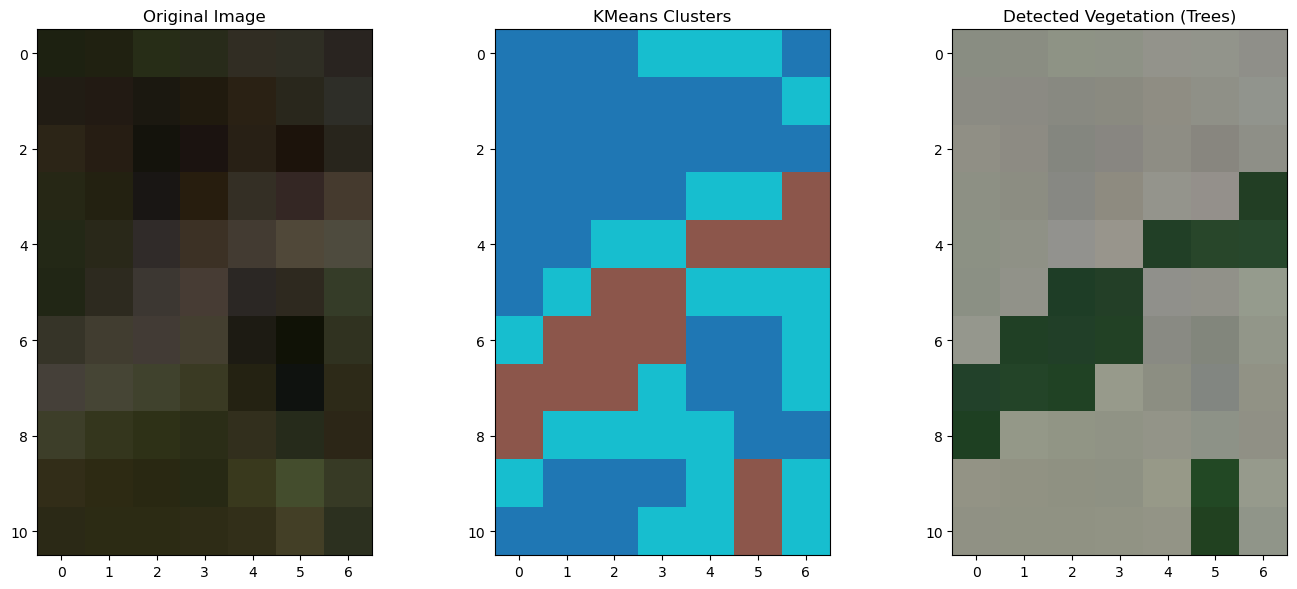

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image

# -------------------------------------------------------------
# Load your single Sentinel image (tree_1.png)
# -------------------------------------------------------------
image_path = "sentinel_tree_images/tree_1.png"  # adjust if needed
img = Image.open(image_path).convert("RGB")
img_np = np.array(img)

# Flatten the image pixels into (N, 3) for clustering
pixels = img_np.reshape(-1, 3)

# -------------------------------------------------------------
# K-Means clustering (2 or 3 clusters)
# -------------------------------------------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pixels)
labels = kmeans.labels_.reshape(img_np.shape[:2])

# Find which cluster is "greenest"
cluster_means = kmeans.cluster_centers_
green_index = np.argmax(cluster_means[:, 1])  # green channel = index 1

# Create a vegetation mask
tree_mask = (labels == green_index)

# -------------------------------------------------------------
# Visualize
# -------------------------------------------------------------
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(labels, cmap="tab10")
plt.title("KMeans Clusters")

plt.subplot(1, 3, 3)
plt.imshow(img)
plt.imshow(tree_mask, cmap="Greens", alpha=0.5)
plt.title("Detected Vegetation (Trees)")

plt.tight_layout()
plt.show()
